In [70]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# Load datasets
file_path_hitters = '/Users/stephenak24/Downloads/2023_hitters.csv'
file_path_owar = '/Users/stephenak24/Downloads/baseball_2023_war.csv'
file_path_pulled_fb = '/Users/stephenak24/Downloads/pulled_flyball_2023.csv'
file_path_straightaway_fb = '/Users/stephenak24/Downloads/straightaway_flyball_2023.csv'
file_path_oppo_fb = '/Users/stephenak24/Downloads/oppo_flyball_2023.csv'
file_path_merged_success = '/Users/stephenak24/Downloads/merged_success_v3.csv'

df_hitters = pd.read_csv(file_path_hitters)
df_owar = pd.read_csv(file_path_owar)
df_pulled_fb = pd.read_csv(file_path_pulled_fb)
df_straightaway_fb = pd.read_csv(file_path_straightaway_fb)
df_oppo_fb = pd.read_csv(file_path_oppo_fb)
df_merged_success = pd.read_csv(file_path_merged_success)

# Create a temporary name column without suffixes for merging
def remove_suffix(name):
    suffixes = [' Jr.', ' III', ' II']
    for suffix in suffixes:
        if name.endswith(suffix):
            return name.replace(suffix, '')
    return name

df_hitters['TempName'] = df_hitters['Name'].apply(remove_suffix)
df_merged_success['TempName'] = df_merged_success['Name'].apply(remove_suffix)

# Merge datasets ensuring 'TempName' is included only once
df_hitters = df_hitters.rename(columns=lambda x: f"{x}_hitters" if x not in ['player_id', 'TempName'] else x)
df_merged_success = df_merged_success.rename(columns=lambda x: f"{x}_merged" if x not in ['player_id', 'TempName'] else x)

merged_final_data = pd.merge(
    df_hitters, 
    df_merged_success, 
    on=['player_id', 'TempName'], how='inner'
)

print(f"Player count after first merge: {len(merged_final_data)}")

# Drop the TempName column
merged_final_data.drop(columns=['TempName'], inplace=True)

# Merging other datasets
merged_final_data = pd.merge(merged_final_data, df_oppo_fb[['player_id', 'oppo_fb%']], on='player_id', how='left')
print(f"Player count after merging oppo_fb: {len(merged_final_data)}")

merged_final_data = pd.merge(merged_final_data, df_pulled_fb[['player_id', 'pulled_fb%']], on='player_id', how='left')
print(f"Player count after merging pulled_fb: {len(merged_final_data)}")

merged_final_data = pd.merge(merged_final_data, df_straightaway_fb[['player_id', 'straightaway_fb%']], on='player_id', how='left')
print(f"Player count after merging straightaway_fb: {len(merged_final_data)}")

merged_final_data = pd.merge(merged_final_data, df_owar[['player_id', 'oWAR']], on='player_id', how='left')
print(f"Player count after merging oWAR: {len(merged_final_data)}")

# Adding oWAR values for missing players
manual_owar = {
    667670: 2.6,  # Brent Rooker
    669004: 1.1,  # MJ Melendez
    650333: 4.7,  # Luis Arraez
    670770: 3.7   # TJ Friedl
}

for player_id, owar_value in manual_owar.items():
    merged_final_data.loc[merged_final_data['player_id'] == player_id, 'oWAR'] = owar_value

# Drop NaN values in the 'oWAR' column
merged_final_data.dropna(subset=['oWAR'], inplace=True)
print(f"Player count after dropping rows with missing oWAR: {len(merged_final_data)}")

# Define metrics for BONDS Index
metrics = [
    'Brls/BBE%_merged', 
    '50th_max_velo_merged', 
    'O-Swing%_merged', 
    'SwStr%_merged', 
    'Z-Swing%_merged', 
    'Z-Contact%_merged', 
    'pulled_fb%', 
    'straightaway_fb%', 
    'oppo_fb%'
]

# Checking if all metrics are in the dataframe
missing_metrics = [metric for metric in metrics if metric not in merged_final_data.columns]
if missing_metrics:
    print(f"Missing metrics: {missing_metrics}")
else:
    # Standardize the metrics
    scaler = StandardScaler()
    X = scaler.fit_transform(merged_final_data[metrics])

    # Define the target variable
    y = merged_final_data['oWAR']

    # Define the Ridge regression model
    ridge = Ridge(alpha=5)
    ridge.fit(X, y)
    coefficients = ridge.coef_

    # Normalize the coefficients to sum up to 1
    weights = coefficients / np.sum(np.abs(coefficients))

    constrained_weights = {metric: weight for metric, weight in zip(metrics, weights)}

    # Calculate the BONDS Index for each player
    merged_final_data['BONDS_Index'] = sum(merged_final_data[metric] * constrained_weights[metric] for metric in metrics)

    # Apply the adjusted scaling for the BONDS Index
    range_bonds_index = merged_final_data['BONDS_Index'].max() - merged_final_data['BONDS_Index'].min()
    mean_bonds_index = merged_final_data['BONDS_Index'].mean()
    merged_final_data['Adjusted Scaling'] = 50 + ((merged_final_data['BONDS_Index'] - mean_bonds_index) / range_bonds_index) * 50

    # Save the final dataframe to a CSV file
    output_file_path = '/Users/stephenak24/Downloads/2023_BONDS_Index.csv'
    merged_final_data[['Name_hitters', 'player_id', 'Adjusted Scaling']].rename(columns={'Adjusted Scaling': 'BONDS Index'}).to_csv(output_file_path, index=False)

    # Check the number of players in the final BONDS Index leaderboard
    final_player_count = merged_final_data.shape[0]
    df_merged_success_player_count = df_merged_success.shape[0]

    print(f"Number of players in merged_success: {df_merged_success_player_count}")
    print(f"Final player count in BONDS Index: {final_player_count}")

    merged_final_data[['Name_hitters', 'player_id', 'Adjusted Scaling']].rename(columns={'Adjusted Scaling': 'BONDS Index'}).head()


Player count after first merge: 134
Player count after merging oppo_fb: 134
Player count after merging pulled_fb: 134
Player count after merging straightaway_fb: 134
Player count after merging oWAR: 134
Player count after dropping rows with missing oWAR: 134
Number of players in merged_success: 134
Final player count in BONDS Index: 134


In [71]:
from sklearn.model_selection import GridSearchCV

# Define the parameter gridf
param_grid = {'alpha': [0.1, 1.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 7.5, 9.0, 10.0, 12.0, 15.0]}

# Use GridSearchCV to find the best alpha
ridge_cv = GridSearchCV(Ridge(), param_grid, cv=5)
ridge_cv.fit(X, y)

# Best alpha value
best_alpha = ridge_cv.best_params_['alpha']
print(f"Best alpha value: {best_alpha}")


Best alpha value: 5.0


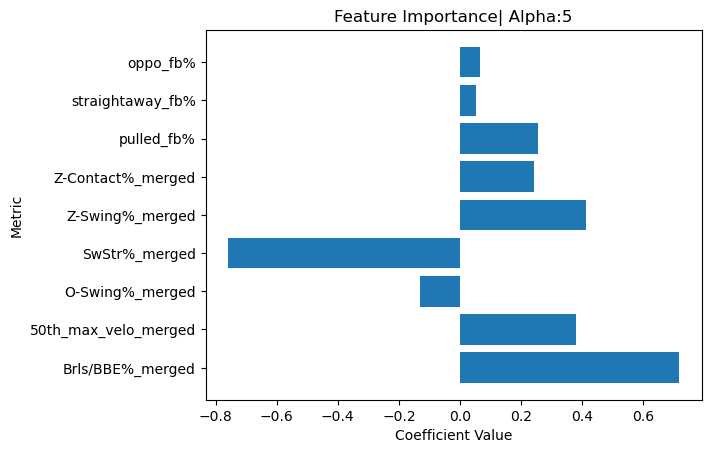

In [72]:
import matplotlib.pyplot as plt

# Plot the coefficients
plt.barh(metrics, ridge.coef_)
plt.xlabel('Coefficient Value')
plt.ylabel('Metric')
plt.title('Feature Importance| Alpha:5')
plt.show()


/Users/stephenak24/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


'/Users/stephenak24/Downloads/bonds_index_distribution.png'

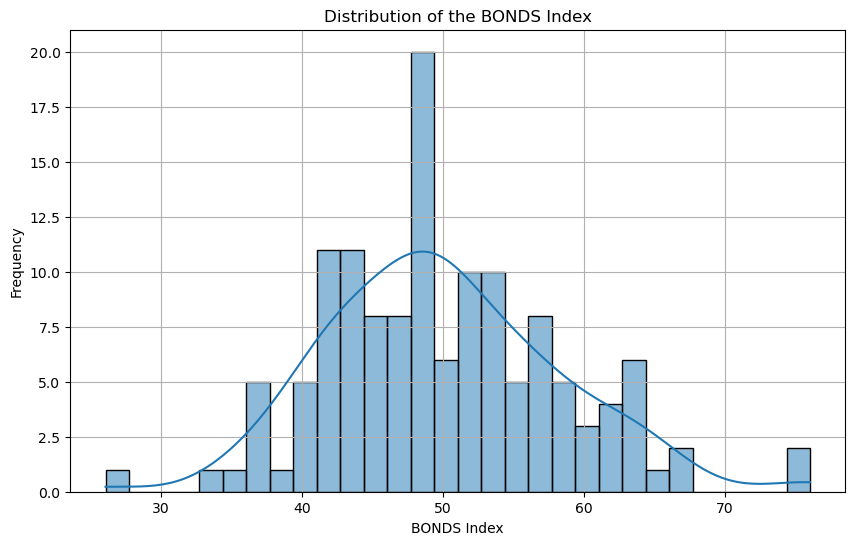

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the BONDS Index
plt.figure(figsize=(10, 6))
sns.histplot(merged_final_data['Adjusted Scaling'], kde=True, bins=30)
plt.title('Distribution of the BONDS Index')
plt.xlabel('BONDS Index')
plt.ylabel('Frequency')
plt.grid(True)
output_image_path = '/Users/stephenak24/Downloads/bonds_index_distribution.png'
plt.savefig(output_image_path)

output_image_path


QQ plot saved to /Users/stephenak24/Downloads/bonds_index_qq_plot.png


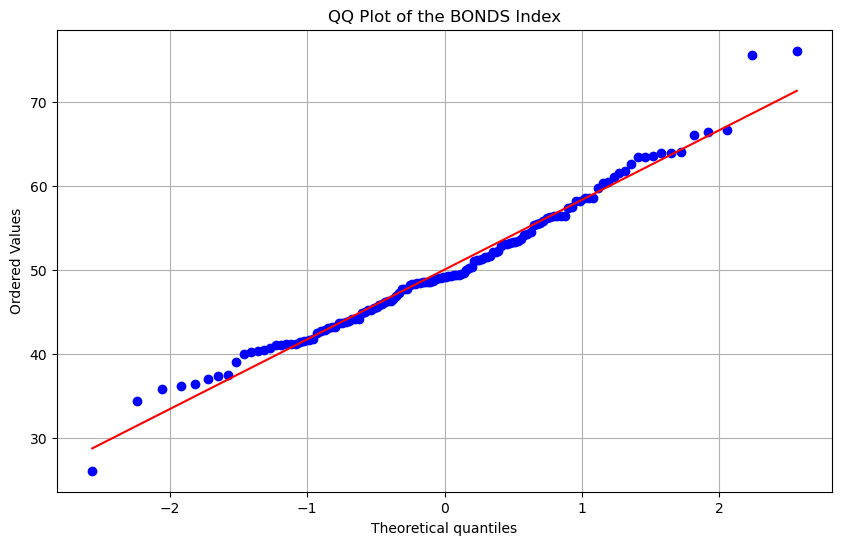

In [74]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Generate QQ plot
plt.figure(figsize=(10, 6))
stats.probplot(merged_final_data['Adjusted Scaling'], dist="norm", plot=plt)
plt.title('QQ Plot of the BONDS Index')
plt.grid(True)
output_qq_image_path = '/Users/stephenak24/Downloads/bonds_index_qq_plot.png'
plt.savefig(output_qq_image_path)

print(f"QQ plot saved to {output_qq_image_path}")


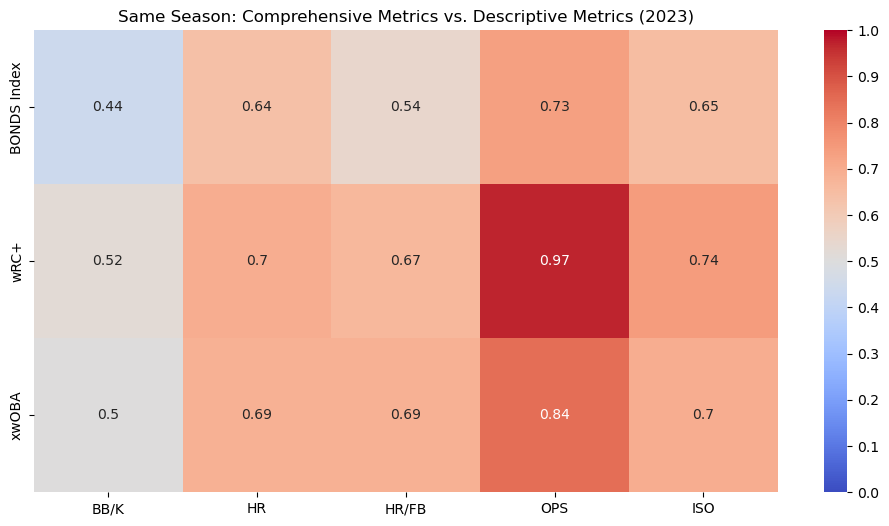

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path_2023_updated = '/Users/stephenak24/Downloads/validation_testing_2023_hitters .csv'
file_path_bonds_2023 = '/Users/stephenak24/Downloads/2023_BONDS_Index.csv'

hitters_2023 = pd.read_csv(file_path_2023_updated)
bonds_2023 = pd.read_csv(file_path_bonds_2023)

# Rename 'Name' to 'player_name' for consistency
hitters_2023 = hitters_2023.rename(columns={'Name': 'player_name'})
bonds_2023 = bonds_2023.rename(columns={'Name_hitters': 'player_name'})

# Merge comprehensive metrics for 2023 with descriptive metrics
merged_2023 = pd.merge(hitters_2023, bonds_2023[['player_name', 'BONDS Index']], on='player_name', how='inner')

# Metrics to validate against
comprehensive_metrics = ['BONDS Index', 'wRC+', 'xwOBA']
descriptive_metrics = ['BB/K', 'HR', 'HR/FB', 'OPS', 'ISO']

# Calculate correlation matrix for 2023
correlation_matrix_2023 = merged_2023[comprehensive_metrics + descriptive_metrics].corr()

# Extract the relevant part of the correlation matrix
correlation_matrix_custom = correlation_matrix_2023.loc[comprehensive_metrics, descriptive_metrics]

# Plot the customized correlation matrix as a heatmap with adjusted color gradient from 0 to 1.0
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix_custom, annot=True, cmap='coolwarm', center=0.5, vmin=0, vmax=1.0, cbar_kws={'ticks': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]})
plt.title('Same Season:  v')
plt.show()


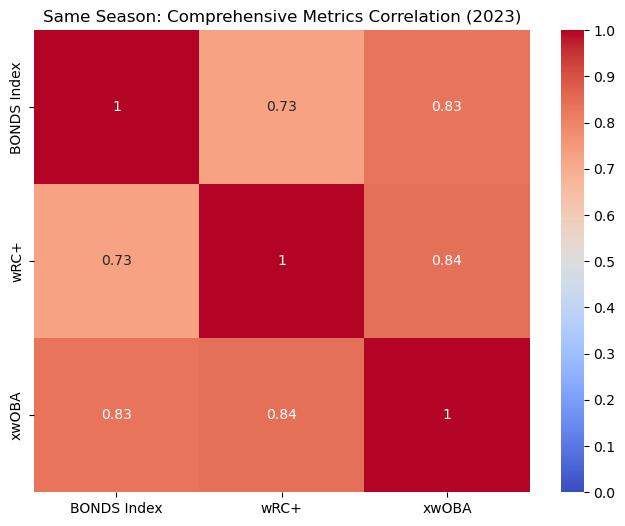

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
file_path_2023_updated = '/Users/stephenak24/Downloads/validation_testing_2023_hitters .csv'
file_path_bonds_2023 = '/Users/stephenak24/Downloads/2023_BONDS_Index.csv'

hitters_2023 = pd.read_csv(file_path_2023_updated)
bonds_2023 = pd.read_csv(file_path_bonds_2023)

# Rename 'Name' to 'player_name' for consistency
hitters_2023 = hitters_2023.rename(columns={'Name': 'player_name'})
bonds_2023 = bonds_2023.rename(columns={'Name_hitters': 'player_name'})

# Merge comprehensive metrics for 2023
merged_2023 = pd.merge(hitters_2023, bonds_2023[['player_name', 'BONDS Index']], on='player_name', how='inner')

# Comprehensive metrics to analyze
comprehensive_metrics = ['BONDS Index', 'wRC+', 'xwOBA']

# Calculate correlation matrix for comprehensive metrics
correlation_matrix_comprehensive = merged_2023[comprehensive_metrics].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_comprehensive, annot=True, cmap='coolwarm', center=0.5, vmin=0, vmax=1.0, cbar_kws={'ticks': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]})
plt.title('Same Season: Comprehensive Metrics Correlation (2023)')
plt.show()


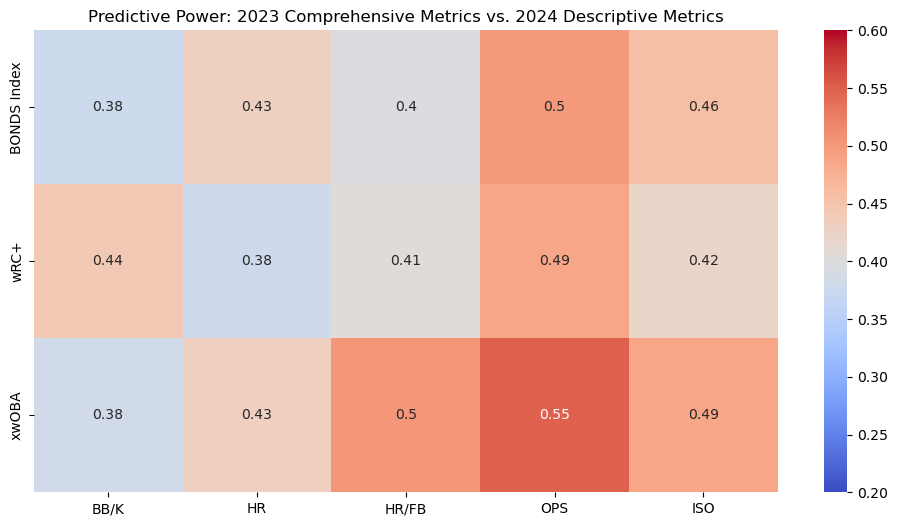

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path_2023_updated = '/Users/stephenak24/Downloads/validation_testing_2023_hitters .csv'
file_path_2024_updated = '/Users/stephenak24/Downloads/validation_testing_2024_hitters.csv'
file_path_bonds_2023 = '/Users/stephenak24/Downloads/2023_BONDS_Index.csv'

hitters_2023 = pd.read_csv(file_path_2023_updated)
hitters_2024 = pd.read_csv(file_path_2024_updated)
bonds_2023 = pd.read_csv(file_path_bonds_2023)

hitters_2023 = hitters_2023.rename(columns={'Name': 'player_name'})
hitters_2024 = hitters_2024.rename(columns={'Name': 'player_name'})
bonds_2023 = bonds_2023.rename(columns={'Name_hitters': 'player_name'})

# Merge comprehensive metrics for 2023 with 2024 descriptive metrics
merged_2024 = pd.merge(hitters_2024, bonds_2023[['player_name', 'BONDS Index']], on='player_name', how='inner')
merged_2024 = pd.merge(merged_2024, hitters_2023[['player_name', 'wRC+', 'xwOBA']], on='player_name', how='inner')

merged_2024 = merged_2024.rename(columns={'wRC+_y': 'wRC+', 'xwOBA_y': 'xwOBA'})

# Metrics to validate against
descriptive_metrics_2024 = ['BB/K', 'HR', 'HR/FB', 'OPS', 'ISO']

# Comprehensive metrics
comprehensive_metrics_corrected = ['BONDS Index', 'wRC+', 'xwOBA']

# Calculate correlation matrix for 2023 comprehensive metrics against 2024 descriptive metrics
correlation_matrix_predictive_corrected = merged_2024[comprehensive_metrics_corrected + descriptive_metrics_2024].corr()

# Extract the relevant part of the correlation matrix
correlation_matrix_predictive_corrected = correlation_matrix_predictive_corrected.loc[comprehensive_metrics_corrected, descriptive_metrics_2024]

# Plot the predictive correlation matrix as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix_predictive_corrected, annot=True, cmap='coolwarm', center=0.4, vmin=0.2, vmax=0.6, cbar_kws={'ticks': [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]})
plt.title('Predictive Power: 2023 Comprehensive Metrics vs. 2024 Descriptive Metrics')
plt.show()